In [1]:
# Import Libraries

%matplotlib inline
import sys
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import time
import matplotlib.dates as mdates
import email
import getpass, imaplib
import os
import sys
import base64
from io import BytesIO

import requests 
requests.packages.urllib3.disable_warnings()
#Requests enables us to download raw html as text
from bs4 import BeautifulSoup 
# BeautifulSoup enables us to navigate html in python with dom-like tree structure 

In [2]:
# Define Scraping Functions

# Define Functions

# Dictionary to store already downloaded BeautifulSoup objects 
html_cache = dict()

# Define functions to use BeautifulSoup
def dl_parsed_html(url, timeout=20, verify=False, sleep_time=1):
    """Downloads the content of the page specified by url.
    Return the parsed HTML or None upon error.
    Notice that timeout, verify, and sleep_time have 
    defaults values"""
    
    # Down load the context at url
    r = requests.get(url, timeout=20,verify=False)
    
    # Check if HTTP status code is anything other than "ok"
    if r.status_code != 200:
        return None
    
    # Grab the raw HTML of the result
    raw_html = r.text
    
    # Parse the raw HTML with Beautiful soup
    soup = BeautifulSoup(raw_html, 'html.parser')
    
    # We have added a default 1 sec sleep
    time.sleep(sleep_time)
    
    # Return the parsed results
    return soup

def get_parsed_html(url, timeout=20, verify=False, sleep_time=1):
    """If we’ve already downloaded a webpage, return from cache. 
    Otherwise, download and parse using dl_parsed_html above."""
    if url not in html_cache:
        parsed_html = dl_parsed_html(url, timeout, verify, sleep_time)
        if parsed_html:
            html_cache[url] = parsed_html 
            
    return html_cache.get(url,None)

# 1. Airports

## A. Zurich Daily Flights

In [3]:
# Scrape

url = "https://www.zurich-airport.com/the-company/noise-policy-and-the-environment/flight-movements/flow-statistics"

soup = get_parsed_html(url)

tables = soup.find_all("table",attrs={"class":"auto-zebra flight-movements-table"})

# Scrape Departures

dct = {}

for el in tables[0].find_all('th'):
    txt = el.text
    dct[txt] = []

keys = list(dct.keys())
    
for el in tables[0].find_all('tr')[2:]:
    
    x = 0
    
    for el1 in el.find_all('td'):
                
        dct[keys[x]].append(el1.text)
        
        x = x+1

departures_df = pd.DataFrame(dct)

date = departures_df.iloc[0, 0]

def safe_date(x):
    return pd.to_datetime(x, format='%d.%m.%Y')

departures_df['Day'] = departures_df[list(departures_df.columns)[0]].apply(safe_date)
departures_df = departures_df.sort_values(by = 'Day', ascending = True)

departures_df['Total'] = departures_df['Total:'].apply(pd.to_numeric)

title = 'departures_as_of_' + date + '.csv'
departures_df.to_csv(title)

# Scrape Arrivals

dct = {}

for el in tables[1].find_all('th'):
    txt = el.text
    dct[txt] = []

keys = list(dct.keys())
    
for el in tables[1].find_all('tr')[2:]:
    
    x = 0
    
    for el1 in el.find_all('td'):
                
        dct[keys[x]].append(el1.text)
        
        x = x+1

arrivals_df = pd.DataFrame(dct)

date = arrivals_df.iloc[0, 0]

def safe_date(x):
    return pd.to_datetime(x, format='%d.%m.%Y')

arrivals_df['Day'] = arrivals_df[list(arrivals_df.columns)[0]].apply(safe_date)
arrivals_df = arrivals_df.sort_values(by = 'Day', ascending = True)

arrivals_df['Total'] = arrivals_df['Total:'].apply(pd.to_numeric)

title = 'arrivals_as_of_' + date + '.csv'
arrivals_df.to_csv(title)
arrivals_df.head()

,RunwayTime,1400-06,1406-22,1422-00,1600-06,1606-22,1622-00,2800-06,2806-22,2822-00,3400-06,3406-22,3422-00,Total:,Day,Total
59,19.03.2020,0,90,0,0,0,0,0,4,2,0,14,0,110,2020-03-19,110
58,20.03.2020,0,86,0,0,0,0,0,10,2,0,8,1,107,2020-03-20,107
57,21.03.2020,0,58,0,0,0,0,0,0,0,0,18,2,78,2020-03-21,78
56,22.03.2020,0,51,1,0,0,0,0,0,0,1,22,0,75,2020-03-22,75
55,23.03.2020,0,39,0,0,0,0,0,0,0,0,7,0,46,2020-03-23,46


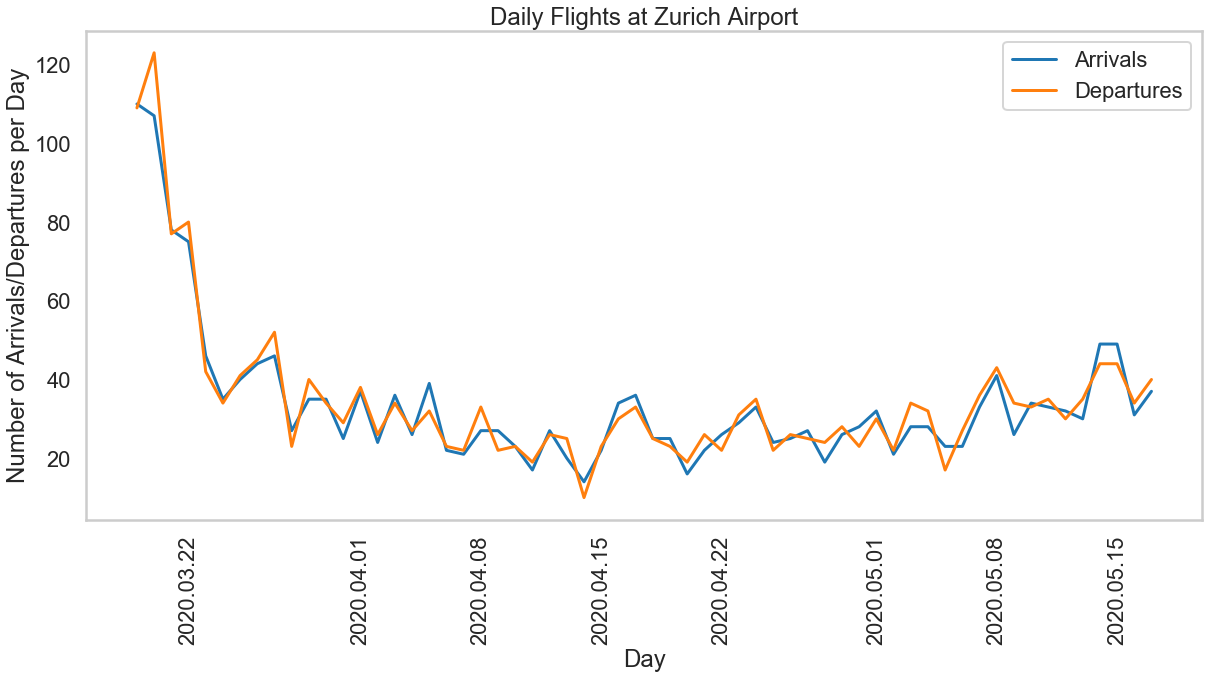

In [4]:
# Plot

fig = plt.figure(figsize=(20,9))
x = sns.lineplot(data=arrivals_df, x='Day', y='Total', label="Arrivals")
y = sns.lineplot(data=departures_df, x='Day', y='Total', label="Departures")
x.set_title('Daily Flights at Zurich Airport')
x.set_xlabel('Day')
x.set_ylabel('Number of Arrivals/Departures per Day')
x.grid(False)
#x.set_xticks(list(arrivals_df['Day'].values)[0::7], minor=True)
x.xaxis.set_major_locator(mdates.AutoDateLocator())
x.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))
plt.setp(x.get_xticklabels(), rotation=90)
x.legend()

_______________________________________________________________________________________________________________________________

## B. TSA Daily Flights

In [5]:
#Scrape

url = "https://www.tsa.gov/coronavirus/passenger-throughput"

soup = get_parsed_html(url)

table = soup.find_all("table")

dct = {}

for el in table[0].find_all('tr')[0].find_all('td'):
    txt = el.text
    dct[txt] = []


keys = list(dct.keys())
    
for el in table[0].find_all('tr')[1:]:
    
    x = 0
    
    for el1 in el.find_all('td'):
                
        dct[keys[x]].append(el1.text)
        
        x = x+1

tsa_df = pd.DataFrame(dct)

date = tsa_df.iloc[0, 0]
new_string = date.split('/')[0]
for el in date.split('/')[1:]:
    new_string = new_string + '-' + el

title = 'TSA Data as of ' + new_string + '.csv'

def safe_date(x):
    return pd.to_datetime(x, format='%m/%d/%Y')

tsa_df['Day'] = tsa_df[list(tsa_df.columns)[0]].apply(safe_date)
tsa_df = tsa_df.sort_values(by = 'Day', ascending = True)

import locale
locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 

tsa_df['Total Traveler Throughput'] = tsa_df['Total Traveler Throughput'].apply(locale.atoi)

tsa_df['Total Traveler Throughput\n\t\t\t(1 Year Ago - Same Weekday)'] = tsa_df['Total Traveler Throughput\n\t\t\t(1 Year Ago - Same Weekday)'].apply(locale.atoi)


tsa_df.to_csv(title)

tsa_df.head()

,Date,Total Traveler Throughput,Total Traveler Throughput\n\t\t\t(1 Year Ago - Same Weekday),Day
77,3/1/2020,2280522,2301439,2020-03-01
76,3/2/2020,2089641,2257920,2020-03-02
75,3/3/2020,1736393,1979558,2020-03-03
74,3/4/2020,1877401,2143619,2020-03-04
73,3/5/2020,2130015,2402692,2020-03-05


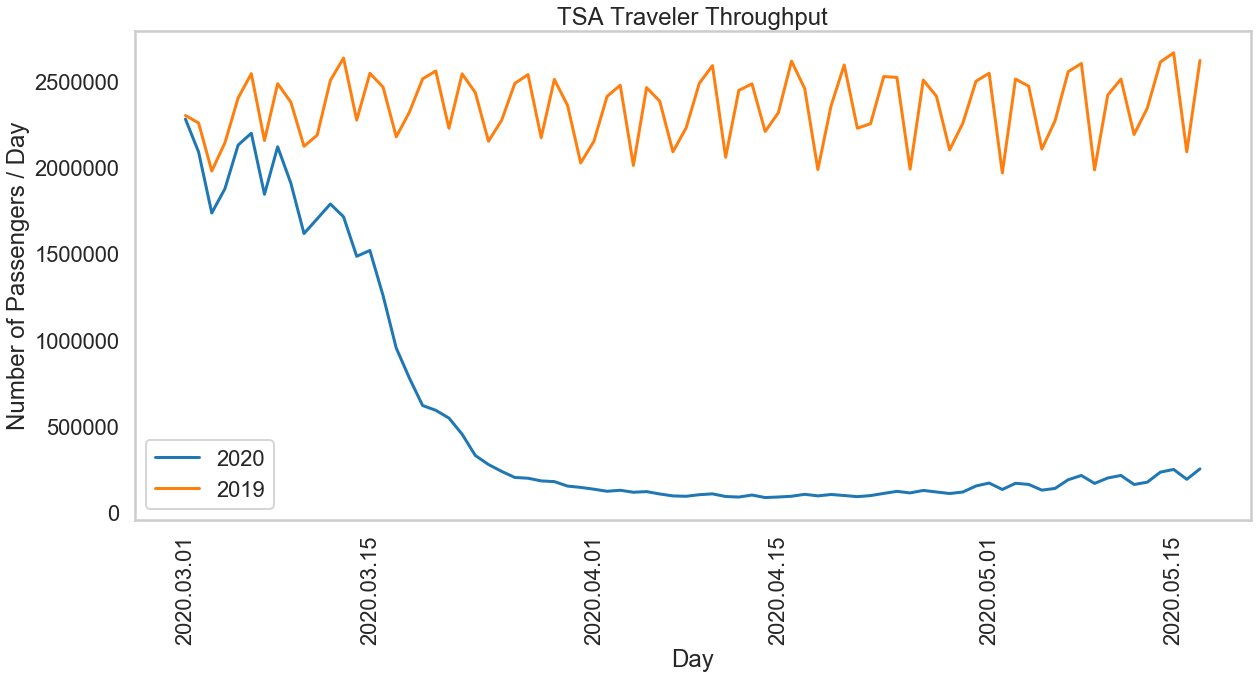

In [6]:
# Plot

fig = plt.figure(figsize=(20,9))
x = sns.lineplot(data=tsa_df, x='Day', y='Total Traveler Throughput', label="2020")
y = sns.lineplot(data=tsa_df, x='Day', y='Total Traveler Throughput\n\t\t\t(1 Year Ago - Same Weekday)', label="2019")
x.set_title('TSA Traveler Throughput')
x.set_xlabel('Day')
x.set_ylabel('Number of Passengers / Day')
x.grid(False)
x.xaxis.set_major_locator(mdates.AutoDateLocator())
x.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))
plt.setp(x.get_xticklabels(), rotation=90)
x.legend()

_______________________________________________________________________________________________________________________________

## C. European Flights - Eurocontrol

In [7]:
# Come back to this

url = "https://www.eurocontrol.int/Economics/DailyTrafficVariation-States.html"

soup = get_parsed_html(url)

#from selenium import webdriver
#driver = webdriver.Chrome()
#url ='https://www.eurocontrol.int/Economics/DailyTrafficVariation-States.html'
#driver.get(url)
#page = driver.execute_script('https://www.gstatic.com/charts/loader.js')
#soup = BeautifulSoup(''.join(page), 'html.parser')

_______________________________________________________________________________________________________________________________

# 2. Mobility

## A. EIA Gasoline Consumption

In [8]:
# Scrape

url = "https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=PET&s=WGFUPUS2&f=W"

soup = get_parsed_html(url)

table = soup.find_all("table")

dct = {'Date': [], 'Value': []}

for el in table[4].find_all('tr')[2:]:
    
    lst = el.find_all('td')
    
    if len(lst) == 1:
        continue
    
    year = lst[0].text.replace('\xa0', '').split('-')[0]

    x1 = lst[1].text.replace('\xa0', '')

    if len(x1) > 0:
    
        date = x1 + '/' + year
        dct['Date'].append(date)
    
        dct['Value'].append(lst[2].text.replace('\xa0', ''))
    
    x2 = lst[3].text.replace('\xa0', '')

    if len(x2) > 0:
    
        date = x2 + '/' + year
        dct['Date'].append(date)
    
        dct['Value'].append(lst[4].text.replace('\xa0', ''))

    x3 = lst[5].text.replace('\xa0', '')
    
    if len(x3) > 0:
    
        date = x3 + '/' + year
        dct['Date'].append(date)
    
        dct['Value'].append(lst[6].text.replace('\xa0', ''))
    
    x4 = lst[7].text.replace('\xa0', '')

    if len(x4) > 0:
    
        date = x4 + '/' + year
        dct['Date'].append(date)
    
        dct['Value'].append(lst[8].text.replace('\xa0', ''))
    
    x5 = lst[9].text.replace('\xa0', '')
    
    if len(x5) > 0:
    
        date = x5 + '/' + year
        dct['Date'].append(date)
    
        dct['Value'].append(lst[10].text.replace('\xa0', ''))

        
eia_df = pd.DataFrame(dct)

def safe_date(x):
    return pd.to_datetime(x, format='%m/%d/%Y')

eia_df['Day'] = eia_df[list(tsa_df.columns)[0]].apply(safe_date)
eia_df = eia_df.sort_values(by = 'Day', ascending = True)

date = eia_df.iloc[-1, 0]
new_string = date.split('/')[0]
for el in date.split('/')[1:]:
    new_string = new_string + '-' + el

title = 'EIA Gasoline Data as of ' + new_string + '.csv'

import locale
locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 

eia_df['Value'] = eia_df['Value'].apply(locale.atoi)

eia_df.to_csv(title)

eia_df.head()

,Date,Value,Day
0,02/08/1991,6621,1991-02-08
1,02/15/1991,6433,1991-02-15
2,02/22/1991,6582,1991-02-22
3,03/01/1991,7224,1991-03-01
4,03/08/1991,6875,1991-03-08


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

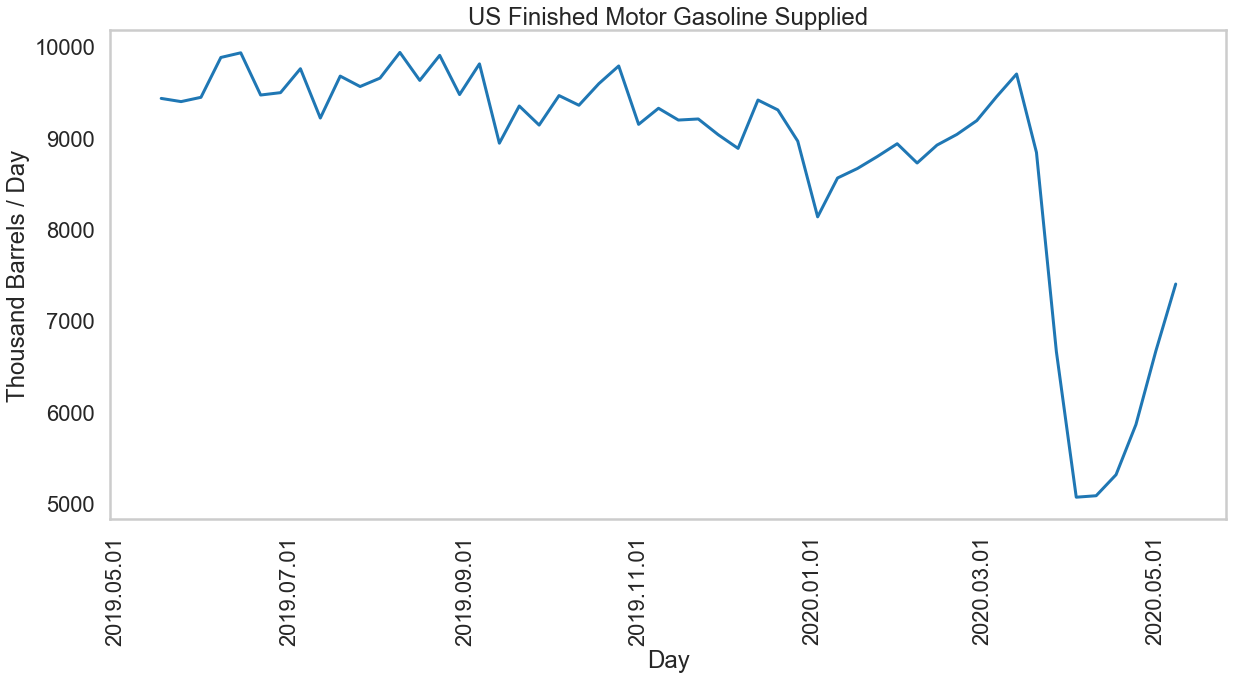

In [9]:
# Plot

smaller_eia = eia_df.iloc[-52:]

fig = plt.figure(figsize=(20,9))
x = sns.lineplot(data=smaller_eia, x='Day', y='Value')
x.set_title('US Finished Motor Gasoline Supplied')
x.set_xlabel('Day')
x.set_ylabel('Thousand Barrels / Day')
x.grid(False)
x.xaxis.set_major_locator(mdates.AutoDateLocator())
x.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))
plt.setp(x.get_xticklabels(), rotation=90)

_______________________________________________________________________________________________________________________________

## B. Google Mobility

In [10]:
# Grab dataframe

url="https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv"

google_df = pd.read_csv(url)

def safe_date(x):
    return pd.to_datetime(x, format='%Y-%m-%d')

us_df = google_df[(google_df['country_region_code'] == 'US') & (google_df['sub_region_1'].isna())]
us_df['Day'] = us_df[list(us_df.columns)[4]].apply(safe_date)

ny_df = google_df[(google_df['country_region_code'] == 'US') & (google_df['sub_region_1'] == 'New York')
                 & (google_df['sub_region_2'].isna())]
ny_df['Day'] = ny_df[list(ny_df.columns)[4]].apply(safe_date)


nyc_df = google_df[(google_df['country_region_code'] == 'US') & (google_df['sub_region_1'] == 'New York')
                 & (google_df['sub_region_2'] == 'New York County')]
nyc_df['Day'] = nyc_df[list(nyc_df.columns)[4]].apply(safe_date)


ca_df = google_df[(google_df['country_region_code'] == 'US') & (google_df['sub_region_1'] == 'California')
                 & (google_df['sub_region_2'].isna())]
ca_df['Day'] = ca_df[list(ca_df.columns)[4]].apply(safe_date)


tx_df = google_df[(google_df['country_region_code'] == 'US') & (google_df['sub_region_1'] == 'Texas')
                 & (google_df['sub_region_2'].isna())]
tx_df['Day'] = tx_df[list(tx_df.columns)[4]].apply(safe_date)

google_df.head()

C:\Users\mark\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\mark\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\mark\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

,country_region_code,country_region,sub_region_1,sub_region_2,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,AE,United Arab Emirates,NaN,NaN,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,AE,United Arab Emirates,NaN,NaN,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0
3,AE,United Arab Emirates,NaN,NaN,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0
4,AE,United Arab Emirates,NaN,NaN,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0


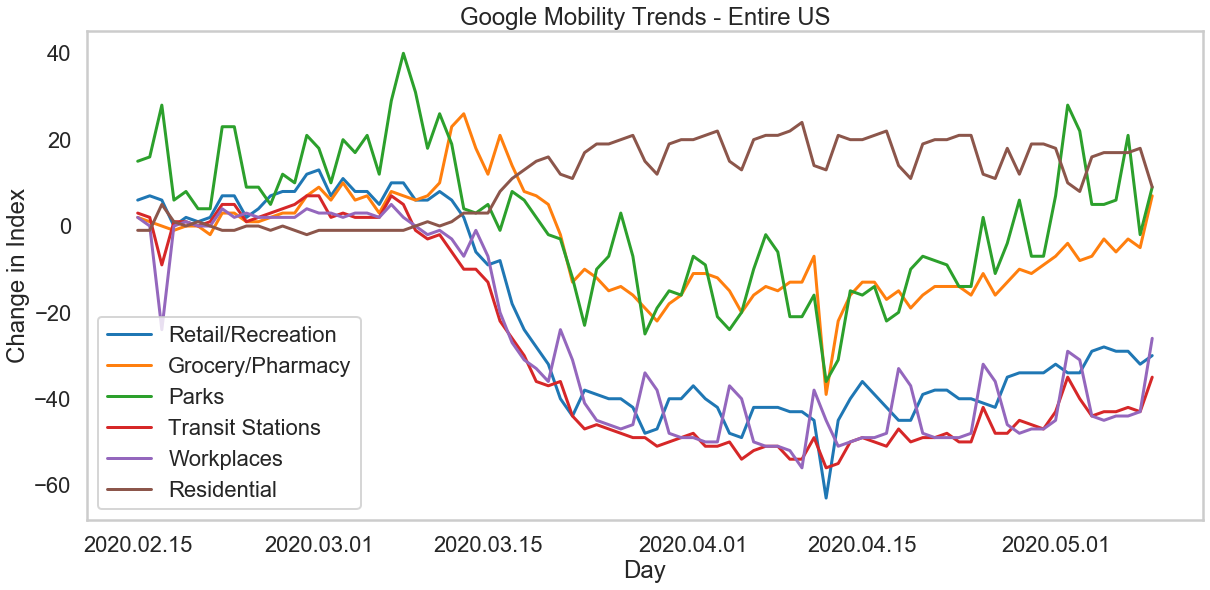

In [11]:
# US Plot

fig = plt.figure(figsize=(20,9))
x1 = sns.lineplot(data=us_df, x='Day', y='retail_and_recreation_percent_change_from_baseline', label="Retail/Recreation")
x2 = sns.lineplot(data=us_df, x='Day', y='grocery_and_pharmacy_percent_change_from_baseline', label="Grocery/Pharmacy")
x3 = sns.lineplot(data=us_df, x='Day', y='parks_percent_change_from_baseline', label="Parks")
x4 = sns.lineplot(data=us_df, x='Day', y='transit_stations_percent_change_from_baseline', label="Transit Stations")
x5 = sns.lineplot(data=us_df, x='Day', y='workplaces_percent_change_from_baseline', label="Workplaces")
x6 = sns.lineplot(data=us_df, x='Day', y='residential_percent_change_from_baseline', label="Residential")

x1.set_title('Google Mobility Trends - Entire US')
x1.set_xlabel('Day')
x1.set_ylabel('Change in Index')
x1.grid(False)
x1.xaxis.set_major_locator(mdates.AutoDateLocator())
x1.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))
plt.setp(x.get_xticklabels(), rotation=90)
x1.legend()

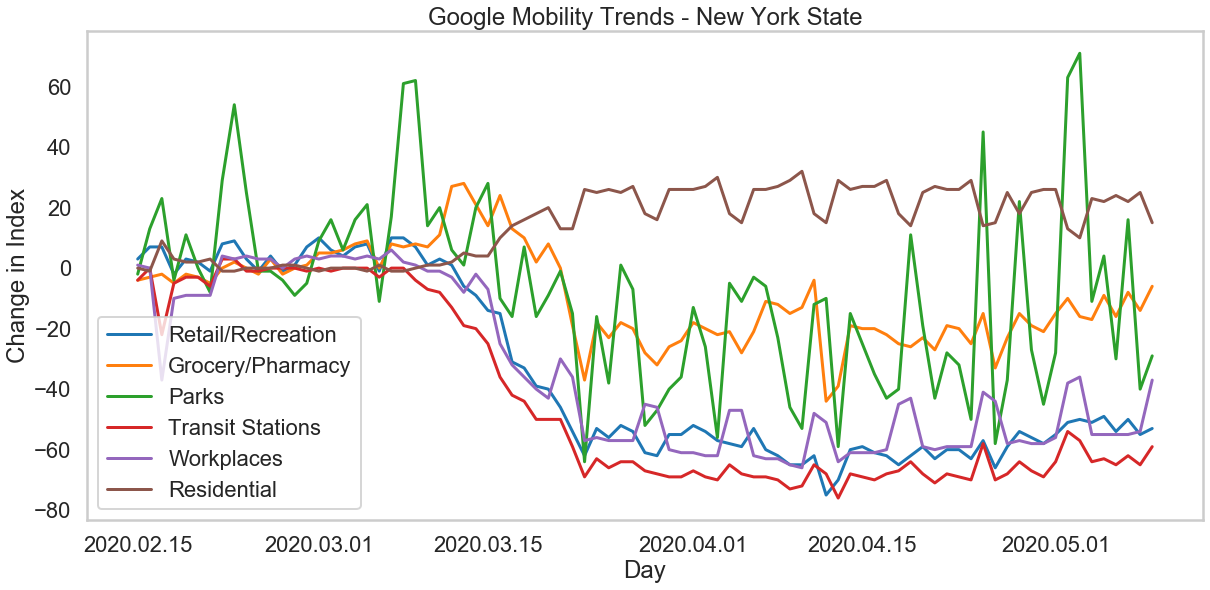

In [12]:
# NY Plot

fig = plt.figure(figsize=(20,9))
x1 = sns.lineplot(data=ny_df, x='Day', y='retail_and_recreation_percent_change_from_baseline', label="Retail/Recreation")
x2 = sns.lineplot(data=ny_df, x='Day', y='grocery_and_pharmacy_percent_change_from_baseline', label="Grocery/Pharmacy")
x3 = sns.lineplot(data=ny_df, x='Day', y='parks_percent_change_from_baseline', label="Parks")
x4 = sns.lineplot(data=ny_df, x='Day', y='transit_stations_percent_change_from_baseline', label="Transit Stations")
x5 = sns.lineplot(data=ny_df, x='Day', y='workplaces_percent_change_from_baseline', label="Workplaces")
x6 = sns.lineplot(data=ny_df, x='Day', y='residential_percent_change_from_baseline', label="Residential")

x1.set_title('Google Mobility Trends - New York State')
x1.set_xlabel('Day')
x1.set_ylabel('Change in Index')
x1.grid(False)
x1.xaxis.set_major_locator(mdates.AutoDateLocator())
x1.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))
plt.setp(x.get_xticklabels(), rotation=90)
x1.legend()

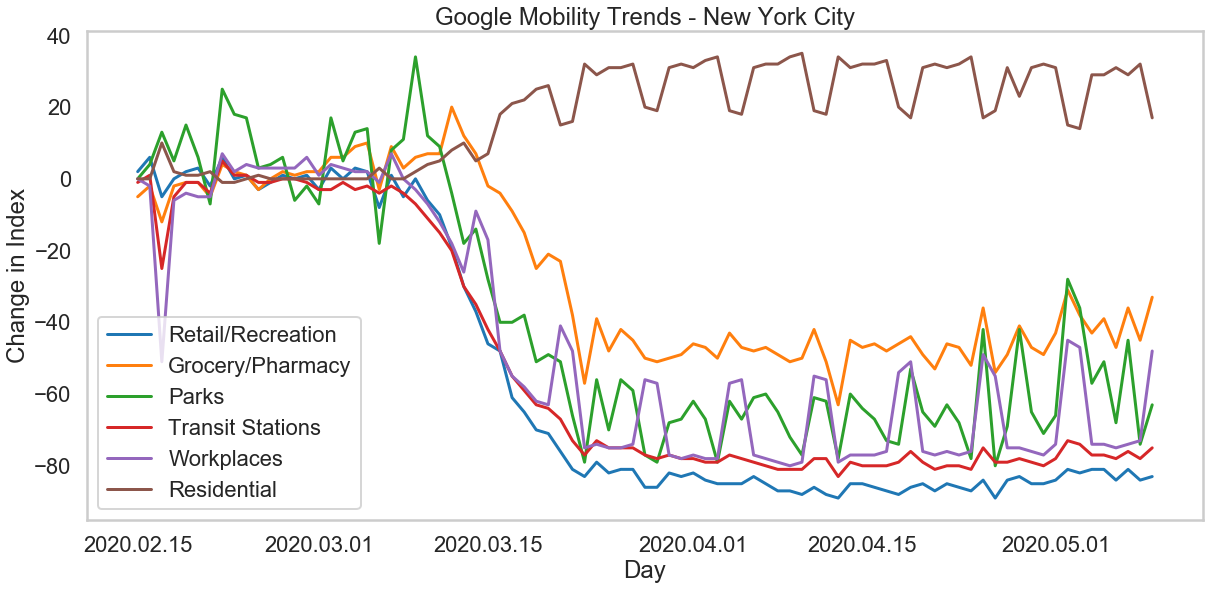

In [13]:
# NYC Plot

fig = plt.figure(figsize=(20,9))
x1 = sns.lineplot(data=nyc_df, x='Day', y='retail_and_recreation_percent_change_from_baseline', label="Retail/Recreation")
x2 = sns.lineplot(data=nyc_df, x='Day', y='grocery_and_pharmacy_percent_change_from_baseline', label="Grocery/Pharmacy")
x3 = sns.lineplot(data=nyc_df, x='Day', y='parks_percent_change_from_baseline', label="Parks")
x4 = sns.lineplot(data=nyc_df, x='Day', y='transit_stations_percent_change_from_baseline', label="Transit Stations")
x5 = sns.lineplot(data=nyc_df, x='Day', y='workplaces_percent_change_from_baseline', label="Workplaces")
x6 = sns.lineplot(data=nyc_df, x='Day', y='residential_percent_change_from_baseline', label="Residential")

x1.set_title('Google Mobility Trends - New York City')
x1.set_xlabel('Day')
x1.set_ylabel('Change in Index')
x1.grid(False)
x1.xaxis.set_major_locator(mdates.AutoDateLocator())
x1.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))
plt.setp(x.get_xticklabels(), rotation=90)
x1.legend()

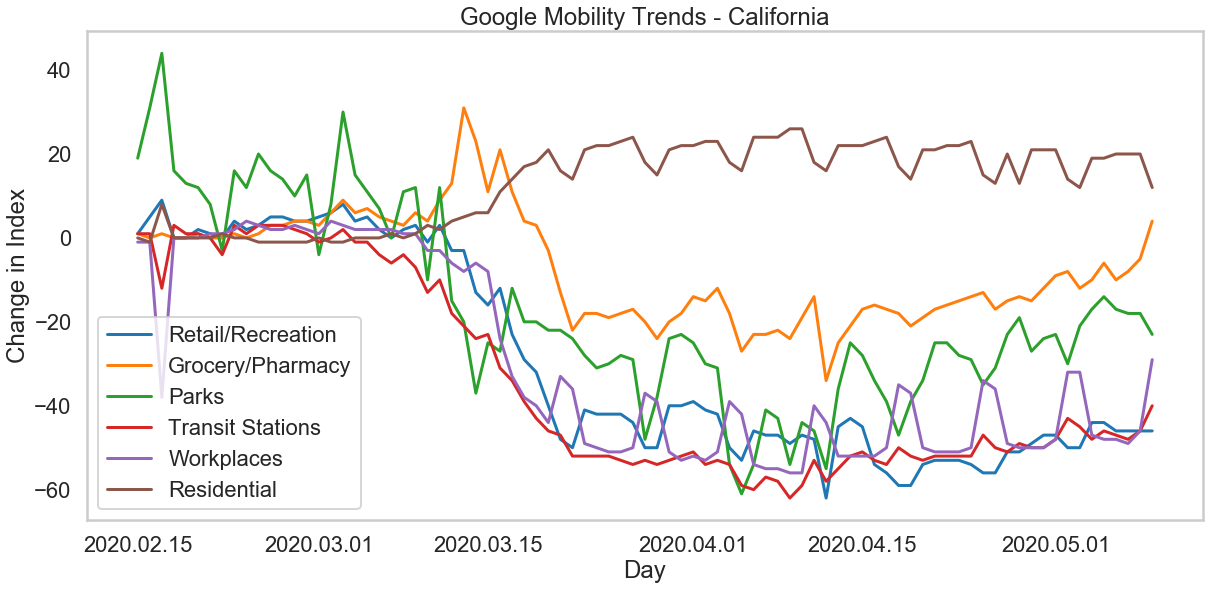

In [14]:
# CA Plot

fig = plt.figure(figsize=(20,9))
x1 = sns.lineplot(data=ca_df, x='Day', y='retail_and_recreation_percent_change_from_baseline', label="Retail/Recreation")
x2 = sns.lineplot(data=ca_df, x='Day', y='grocery_and_pharmacy_percent_change_from_baseline', label="Grocery/Pharmacy")
x3 = sns.lineplot(data=ca_df, x='Day', y='parks_percent_change_from_baseline', label="Parks")
x4 = sns.lineplot(data=ca_df, x='Day', y='transit_stations_percent_change_from_baseline', label="Transit Stations")
x5 = sns.lineplot(data=ca_df, x='Day', y='workplaces_percent_change_from_baseline', label="Workplaces")
x6 = sns.lineplot(data=ca_df, x='Day', y='residential_percent_change_from_baseline', label="Residential")

x1.set_title('Google Mobility Trends - California')
x1.set_xlabel('Day')
x1.set_ylabel('Change in Index')
x1.grid(False)
x1.xaxis.set_major_locator(mdates.AutoDateLocator())
x1.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))
plt.setp(x.get_xticklabels(), rotation=90)
x1.legend()

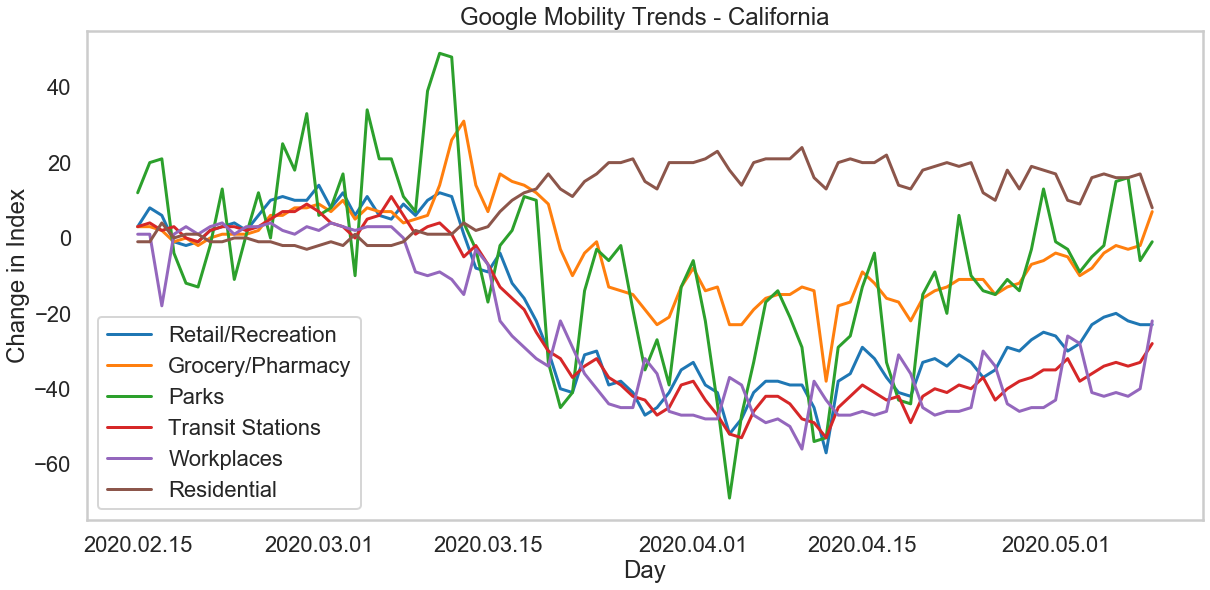

In [15]:
# TX Plot

fig = plt.figure(figsize=(20,9))
x1 = sns.lineplot(data=tx_df, x='Day', y='retail_and_recreation_percent_change_from_baseline', label="Retail/Recreation")
x2 = sns.lineplot(data=tx_df, x='Day', y='grocery_and_pharmacy_percent_change_from_baseline', label="Grocery/Pharmacy")
x3 = sns.lineplot(data=tx_df, x='Day', y='parks_percent_change_from_baseline', label="Parks")
x4 = sns.lineplot(data=tx_df, x='Day', y='transit_stations_percent_change_from_baseline', label="Transit Stations")
x5 = sns.lineplot(data=tx_df, x='Day', y='workplaces_percent_change_from_baseline', label="Workplaces")
x6 = sns.lineplot(data=tx_df, x='Day', y='residential_percent_change_from_baseline', label="Residential")

x1.set_title('Google Mobility Trends - California')
x1.set_xlabel('Day')
x1.set_ylabel('Change in Index')
x1.grid(False)
x1.xaxis.set_major_locator(mdates.AutoDateLocator())
x1.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))
plt.setp(x.get_xticklabels(), rotation=90)
x1.legend()

_______________________________________________________________________________________________________________________________

# 3. Hotel Occupancy

In [16]:
detach_dir = '.'
if 'attachments' not in os.listdir(detach_dir):
    os.mkdir('attachments')
    
userName = "pcdatatestemail@gmail.com"
passwd = getpass.getpass('Enter your password: ')

    
m = imaplib.IMAP4_SSL("imap.gmail.com", 993)
m.login(userName,passwd)
m.select('"[Gmail]/All Mail"')

typ, data = m.search(None, 'ALL')
if typ != 'OK': 
    print('Error searching Inbox.')

for msgId in data[0].split():
    typ, messageParts = m.fetch(msgId, '(RFC822)')
    
    if typ != 'OK':
        print('Error fetching mail')

        
    body = messageParts[0][1]

    mail = email.message_from_bytes(body)

    for part in mail.walk():
        if part.get_content_maintype() == 'multipart':
            # print part.as_string()
            continue
        if part.get('Content-Disposition') is None:
            # print part.as_string()
            continue
        fileName = part.get_filename()
        file = part.get_payload()

        str_csv  = base64.urlsafe_b64decode(file.encode('UTF-8'))
        hotels_df = pd.read_excel(BytesIO(str_csv))

m.close()
m.logout()

Enter your password: ········


('BYE', [b'LOGOUT Requested'])

In [17]:
def safe_date(x):
    return pd.to_datetime(x, format='%Y%m%d')

us_hotel_df = hotels_df[(hotels_df['Segment Name'] == 'United States')]
us_hotel_df['Day'] = us_hotel_df[list(us_hotel_df.columns)[1]].apply(safe_date)

china_hotel_df = hotels_df[(hotels_df['Segment Name'] == 'China')]
china_hotel_df['Day'] = china_hotel_df[list(china_hotel_df.columns)[1]].apply(safe_date)

germany_hotel_df = hotels_df[(hotels_df['Segment Name'] == 'Germany')]
germany_hotel_df['Day'] = germany_hotel_df[list(germany_hotel_df.columns)[1]].apply(safe_date)

C:\Users\mark\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\mark\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mark\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

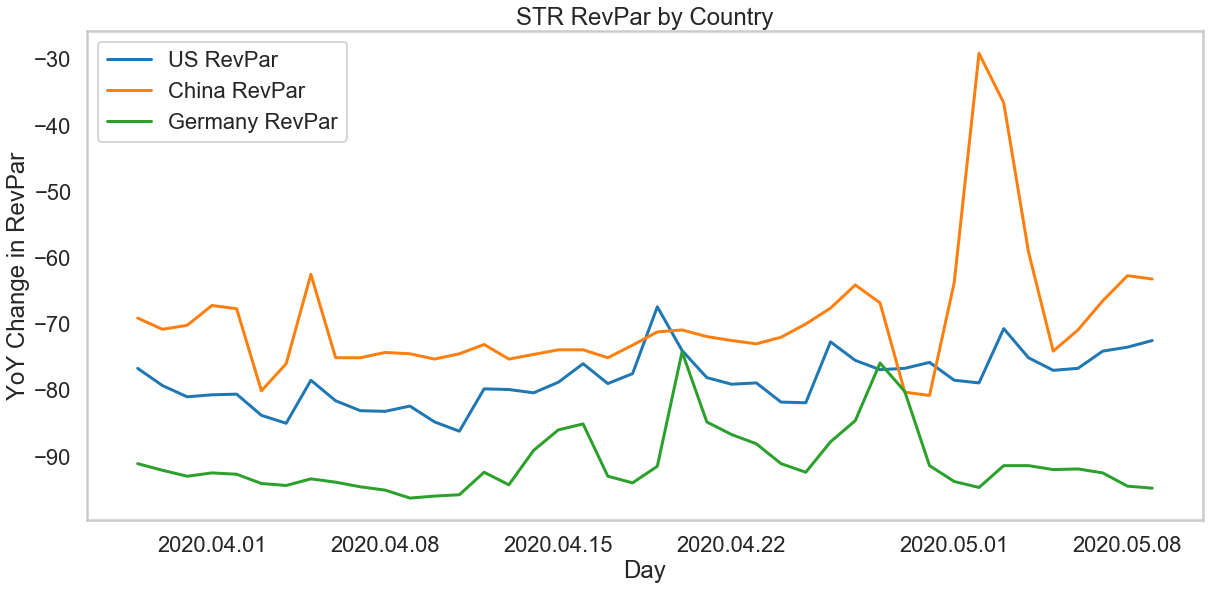

In [18]:
# RevPar Plot

fig = plt.figure(figsize=(20,9))
x1 = sns.lineplot(data=us_hotel_df, x='Day', y='Rooms RevPAR PC', label="US RevPar")
x2 = sns.lineplot(data=china_hotel_df, x='Day', y='Rooms RevPAR PC', label="China RevPar")
x3 = sns.lineplot(data=germany_hotel_df, x='Day', y='Rooms RevPAR PC', label="Germany RevPar")

x1.set_title('RevPar by Country')
x1.set_xlabel('Day')
x1.set_ylabel('YoY Change in RevPar')
x1.grid(False)
x1.xaxis.set_major_locator(mdates.AutoDateLocator())
x1.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))
plt.setp(x.get_xticklabels(), rotation=90)
x1.legend()

_______________________________________________________________________________________________________________________________

# 4. Mortgages